In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nelpy as nel
from scipy.io import savemat, loadmat

/home/kemerelab/nelpy/nelpy/plotting/decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [2]:
from scipy import interpolate
from scipy.signal import savgol_filter

# Bin behavior data

In [4]:
d = np.load('/home/kemerelab/Downloads/mazesEEG/RatS-Day5TwoNovel-2020-12-04_07-55-09.paradigm.npy',allow_pickle=True)
period_names = d.item(0)['epochs']['label'].values
period = np.vstack((d.item(0)['epochs']['start'].values,d.item(0)['epochs']['stop'].values))
period_bounds = nel.EpochArray(period.T)
period_names, period_bounds.data

(array(['pre', 'maze1', 'post1', 'maze2', 'post2'], dtype=object),
 array([[    0, 11066],
        [11070, 13970],
        [13972, 20754],
        [20756, 24004],
        [24006, 42305]]))

In [16]:
# Define maze ID
maze_id = 1
period_names[maze_id]

'maze1'

In [17]:
pos_lin = nel.load_pkl(period_names[maze_id]+'_raw_pos.nel')
mazetime = pos_lin.abscissa_vals
pos_1d = pos_lin.data.squeeze()
mazetime.shape, pos_1d.shape

((174000,), (174000,))

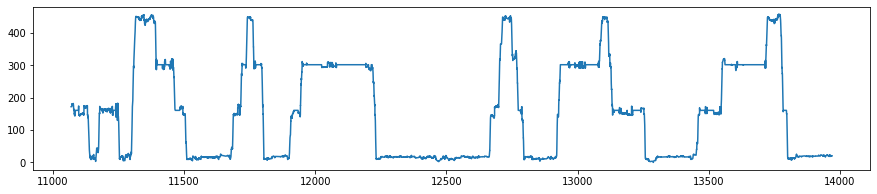

In [18]:
plt.figure(figsize=(15,3))
plt.plot(mazetime,pos_1d)

## speed sanity check

In [19]:
mazetime[0],mazetime[-1],period_bounds[maze_id].data

(11070.004361107587, 13969.988836910596, array([[11070, 13970]]))

In [20]:
tbin = 0.5 # speed is computed in 50ms time bin
time = np.arange(period_bounds[maze_id].data[0,0]+10,period_bounds[maze_id].data[0,1]-9,tbin)
time.shape, time[0],time[-1]

((5762,), 11080.0, 13960.5)

In [21]:
f = interpolate.interp1d(mazetime,pos_1d)
pos_linear = f(time)
speed_linear = np.abs(np.gradient(pos_linear))/tbin
speed_linear.shape, pos_linear.shape

((5762,), (5762,))

In [22]:
position = np.load('RatS-Day5TwoNovel-2020-12-04_07-55-09_position.npy',allow_pickle=True)
timestamps = position.item(0)['time']
x1 = position.item(0)['x']
y1 = position.item(0)['y']
timestamps.shape, x1.shape, y1.shape

((2538347,), (2538347,), (2538347,))

In [23]:
f = interpolate.interp1d(timestamps,np.vstack((x1, y1)))
pos_origin = f(time)
pos_origin.shape

(2, 5762)

In [24]:
dic={'time_all': time, 'pos_linear': pos_linear, 'pos_origin': pos_origin}
dic

{'time_all': array([11080. , 11080.5, 11081. , ..., 13959.5, 13960. , 13960.5]),
 'pos_linear': array([160.73936621, 160.73936621, 160.73936621, ...,  21.2261246 ,
         19.74302485,  19.73325621]),
 'pos_origin': array([[-58.74814349, -60.19980849, -57.2301462 , ...,  83.58932321,
          84.92365669,  84.78598642],
        [-58.40559676, -53.94984348, -60.53147475, ..., -64.64847402,
         -68.97539318, -73.23846349]])}

In [25]:
savemat('maze1_pos_500ms.mat',dic)

In [11]:
speed_linear_gra = np.diff(speed_linear)

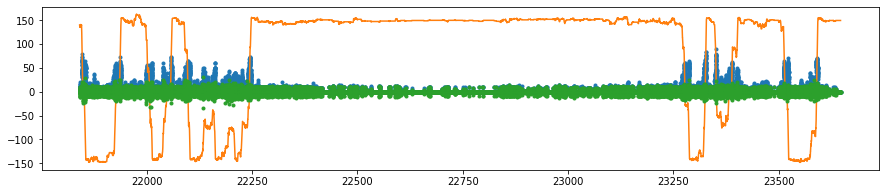

In [13]:
plt.figure(figsize=(15,3))
rangeidx = [21500,57610]
# rangeidx = [12600, 12750]
plt.plot(time[rangeidx[0]:rangeidx[1]],speed_linear[rangeidx[0]:rangeidx[1]],'.')
plt.plot(time[rangeidx[0]:rangeidx[1]],pos_linear[rangeidx[0]:rangeidx[1]])
plt.plot(time[rangeidx[0]:rangeidx[1]],speed_linear_gra[rangeidx[0]:rangeidx[1]],'.')

Text(0.5, 1.0, 'histogram of speed')

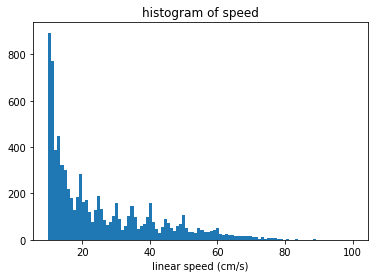

In [14]:
plt.hist(speed_linear,bins=100,range=(10,100))
plt.xlabel('linear speed (cm/s)')
plt.title('histogram of speed')

In [15]:
# exclude speed outliers before smoothing speed
f = interpolate.interp1d(time[np.where(speed_linear<80)],speed_linear[np.where(speed_linear<80)])
speed_linear_sm = f(time)

In [16]:
speed_linear = speed_linear_sm.copy()

In [28]:
v1=3
v2=5
filter_win=21
plot=False
display_range=[21500,22550]

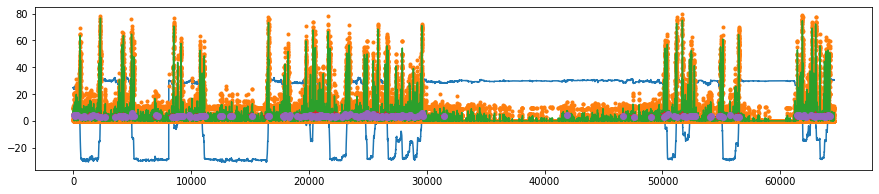

In [29]:
speed = np.abs(savgol_filter(speed_linear, filter_win, 2))
spd_thr = np.where(speed>v1)[0]
idx_end = np.where(np.diff(spd_thr)>1)[0]
idx_end = np.append(idx_end,len(spd_thr)-1)
idx_st = idx_end[:-1]+1
idx_st = np.insert(idx_st,0,0)

idx_st_thr = []
idx_end_thr = []
epocharray = []
for i in range(len(idx_st)):
    if np.where(speed[spd_thr[idx_st[i]:idx_end[i]]]>v2)[0].shape[0]>20: # speed>v1 for at least 0.05s*20=1s
        idx_st_thr.append(spd_thr[idx_st[i]])
        idx_end_thr.append(spd_thr[idx_end[i]])
        epocharray.append([time[idx_st_thr[-1]],time[idx_end_thr[-1]]])
idx_st_thr = np.array(idx_st_thr)
idx_end_thr = np.array(idx_end_thr)

plt.figure(figsize=(15,3))
# rangeidx = [12600, 12750]
# plt.plot(time[rangeidx[0]:rangeidx[1]],speed_linear[rangeidx[0]:rangeidx[1]],'.')
plt.plot(pos_linear/5)
plt.plot(speed_linear_sm,'.')
plt.plot(speed)
# plt.plot(spd_thr[idx_st],speed[spd_thr[idx_st]],'*')
# plt.plot(spd_thr[idx_end],speed[spd_thr[idx_end]],'o')
plt.plot(idx_st_thr,speed[idx_st_thr],'*')
plt.plot(idx_end_thr,speed[idx_end_thr],'o')

# plt.xlim(display_range)

In [30]:
run_epoch = nel.EpochArray(epocharray)
run_epoch

<EpochArray at 0x7ff84e142df0: 182 epochs> of length 10:26:700 minutes

In [31]:
pos_run = pos_lin[run_epoch].data
pos_run.shape

(1, 37602)

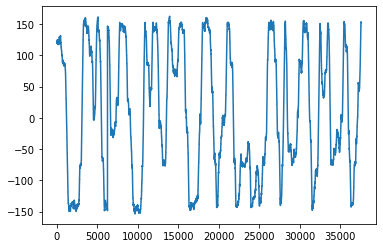

In [32]:
plt.plot(pos_run.squeeze())

In [40]:
mazetime.shape, pos_1d.shape

((194880,), (194880,))

In [33]:
nel.save_pkl(period_names[maze_id]+'_runepoch_'+str(v1)+'_'+str(v2)+'.nel',run_epoch)

## run

In [54]:
run_epoch = nel.load_pkl('maze1_runepoch_3_5.nel')

In [55]:
period_bounds[maze_id] , run_epoch

(<EpochArray at 0x7ff8452c9ac0: 1 epoch> of length 54:08 minutes,
 <EpochArray at 0x7ff8452c9d60: 154 epochs> of length 7:30:350 minutes)

In [56]:
d = np.load('RatS-Day5TwoNovel-2020-12-04_07-55-09_spikes.npy',allow_pickle=True)
st = nel.SpikeTrainArray(timestamps=d.item(0)['times'],support=run_epoch) # running epochs

In [58]:
spikes = st.bin(ds=0.5)
spikes, spikes.bin_centers

(<BinnedSpikeTrainArray at 0x7ff8521ed070: 109 ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109'] (154 segments) in 815 bins of width 500.0 milliseconds> for a total of 6:47:500 minutes,
 array([11080.75      , 11081.25      , 11084.8       , 11085.3       ,
        11085.8       , 11097.8       , 11098.3       , 11113.7       ,
        11114.2       , 11114.7       , 11115.2       , 11115.7 

In [65]:
mazetime[[0,-1]],spikes.bin_centers[[0,-1]]

(array([11070.00436111, 13969.98883691]),
 array([11080.75      , 13800.54999996]))

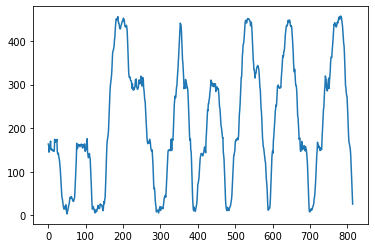

In [66]:
f = interpolate.interp1d(mazetime,pos_1d)
pos_linear_spk = f(spikes.bin_centers)
plt.plot(pos_linear_spk)

In [67]:
dic = {"pos_linear": pos_linear_spk, "time": spikes.bin_centers, "spikes": spikes.data, "info":['savgol_filter width: 21','minimum running epoch length: 0.05s*20','time bin size: 500ms']}
dic

{'pos_linear': array([163.42401262, 160.73936621, 144.82122714, 151.26368059,
        155.83449956, 160.73936621, 170.26095002, 151.85896963,
        150.13925771, 152.63860427, 150.13585702, 149.62866344,
        150.31331995, 147.23551097, 147.62340645, 146.64426972,
        147.67181099, 174.46629736, 170.45423426, 167.72835489,
        170.70364066, 173.16696801, 169.9163624 , 174.0877788 ,
        146.91426825, 142.55296548, 140.11351392, 142.30588534,
        133.72585145, 130.54325036, 125.01432876, 116.22346942,
        106.16036016,  92.2827679 ,  77.05913368,  61.32548643,
         46.38811178,  39.10427097,  35.70029544,  28.74378259,
         21.51791902,  17.07606599,  13.93231085,  16.7226949 ,
         18.99366788,  20.9927394 ,  14.64259831,  24.03589062,
         15.73027468,   7.3141565 ,   3.10508525,   6.44098342,
         10.72767256,  15.4790604 ,  20.18972532,  23.91994026,
         27.31232506,  33.82880181,  40.96053806,  40.22113277,
         38.98558931,  43.

In [69]:
name = period_names[maze_id]+'_run_v1_'+str(v1)+'_v2_'+str(v2)+'_500ms_new.mat'
name

'maze1_run_v1_3_v2_5_500ms_new.mat'

In [70]:
savemat(name,dic)

In [19]:
name = 'maze2_run_v1_3_v2_5_500ms_new.mat'
time = loadmat(name)['time'].squeeze()
pos_linear_spk = loadmat(name)['pos_linear'].squeeze()
time.shape,pos_linear_spk.shape

((1156,), (1156,))

In [5]:
position = np.load('RatS-Day5TwoNovel-2020-12-04_07-55-09_position.npy',allow_pickle=True)
timestamps = position.item(0)['time']
x1 = position.item(0)['x']
y1 = position.item(0)['y']
np.vstack((x1, y1)).shape, timestamps.shape

((2, 2538347), (2538347,))

In [20]:
timestamps[[0,-1]], time[[0,-1]]

(array([    0.        , 42305.78333333]),
 array([20768.15      , 23976.59999995]))

In [21]:
f = interpolate.interp1d(timestamps,np.vstack((x1, y1)))
pos_2d_spkfs = f(time)
pos_2d_spkfs.shape

(2, 1156)

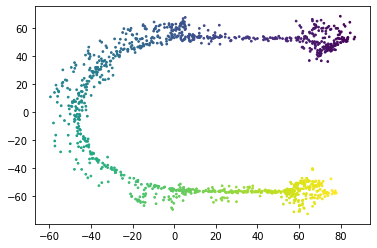

In [22]:
plt.scatter(pos_2d_spkfs[0,:],pos_2d_spkfs[1,:],s=3,c=pos_linear_spk)

In [23]:
dic = {"pos_origin": pos_2d_spkfs}
savemat('maze2_run_v1_3_v2_5_500ms_new_2dpos.mat',dic)

# Bin PBE data

In [ ]:
pbe = np.load('RatS-Day5TwoNovel-2020-12-04_07-55-09.pbe.npy',allow_pickle=True)
pbe.item(0)

In [ ]:
epochs = np.vstack((pbe.item(0)['events']['start'].values,pbe.item(0)['events']['end'].values))
pbe_bounds = nel.EpochArray(epochs.T)
pbe_bounds.data

In [ ]:
d = np.load('RatS-Day5TwoNovel-2020-12-04_07-55-09_spikes.npy',allow_pickle=True)
st = nel.SpikeTrainArray(timestamps=d.item(0)['times'],support=pbe_bounds)
st

In [ ]:
seg = st[period_bounds[0]]
seg.support

In [ ]:
for i in range(1,5):
    seg = st[period_bounds[i]]
    nel.save_pkl(period_names[i]+'.nel', seg)